In [ ]:
!pip install scikit-learn
!pip install rarfile
!apt-get install unrar
!pip install timm

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.9 MB/s eta 0:

In [ ]:
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import zipfile
import glob
import joblib
import torch
import cv2
import os

from sklearn.metrics import confusion_matrix, classification_report
from transformers import SwinForImageClassification, AdamW
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from collections import Counter
from google.colab import drive
from sklearn.svm import SVC
from PIL import Image

In [ ]:
# Mount Google Drive (jika Anda menggunakan Google Colab)
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/MyDrive/Colab Notebooks/plant.zip'  # Sesuaikan path dengan lokasi file Anda
extract_path = "/content/sample_data"

In [ ]:
os.makedirs(extract_path, exist_ok=True)
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Dataset diekstrak ke: {extract_path}")
except (FileNotFoundError, zipfile.BadZipFile) as e:
    print(f"Error: {e}")
    exit()

Dataset diekstrak ke: /content/sample_data


In [ ]:
base_dir = os.path.join(extract_path, "/content/sample_data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train")
if not os.path.exists(base_dir):
    print("Dataset tidak ditemukan atau gagal diekstrak.")
    exit()

class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
num_classes = len(class_dirs)

In [ ]:
# Transformasi data dengan augmentasi
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Split dataset
train_size = int(0.8 * len(base_dir))
val_size = len(base_dir) - train_size
train_dataset, val_dataset = random_split(base_dir, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# Load model Vision Transformer
model = vit_b_16(pretrained=True)
model.heads.head = nn.Linear(model.hidden_dim, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
base_dir = extract_path = "/content/sample_data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train" # Path yang ingin dicek

print("Base directory:", base_dir)

Base directory: /content/sample_data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train


In [ ]:
# --- Analisis Dataset ---
base_dir = extract_path
class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

class_counts = {}
image_paths = []

for class_name in class_dirs:
    class_path = os.path.join(base_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]  # Case-insensitive
    class_counts[class_name] = len(images)

    for img in images:
        image_paths.append(os.path.join(class_path, img))

total_images = sum(class_counts.values())
print(f"\nTotal Images in Dataset: {total_images}")

print("\nTotal Image Per Class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} Images")


Total Images in Dataset: 70295

Total Image Per Class:
Peach___Bacterial_spot: 1838 Images
Pepper,_bell___healthy: 1988 Images
Potato___Early_blight: 1939 Images
Potato___Late_blight: 1939 Images
Grape___Esca_(Black_Measles): 1920 Images
Soybean___healthy: 2022 Images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 1642 Images
Grape___healthy: 1692 Images
Cherry_(including_sour)___Powdery_mildew: 1683 Images
Tomato___Spider_mites Two-spotted_spider_mite: 1741 Images
Tomato___Leaf_Mold: 1882 Images
Tomato___Late_blight: 1851 Images
Apple___healthy: 2008 Images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1722 Images
Grape___Black_rot: 1888 Images
Tomato___Bacterial_spot: 1702 Images
Blueberry___healthy: 1816 Images
Corn_(maize)___Common_rust_: 1907 Images
Tomato___healthy: 1926 Images
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1961 Images
Cherry_(including_sour)___healthy: 1826 Images
Strawberry___healthy: 1824 Images
Orange___Haunglongbing_(Citrus_greening): 2010 Images
Apple___Black_

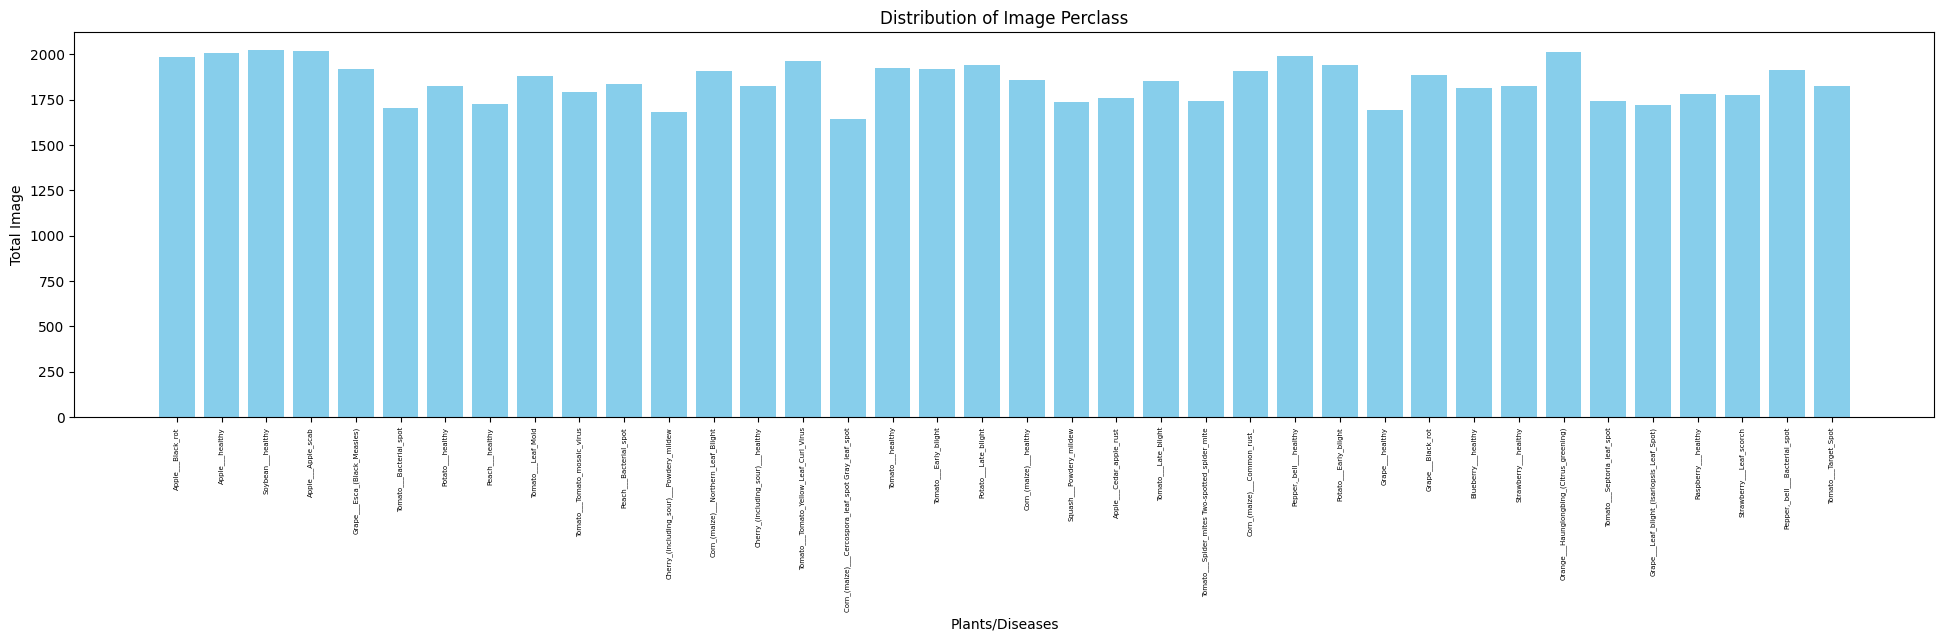

In [ ]:
# Plot distribusi data
index = [n for n in range(38)]
plt.figure(figsize=(24, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel("Total Image")
plt.title("Distribution of Image Perclass")
plt.xticks(fontsize=5, rotation=90)
plt.show()


Analyzing Size of the Image:
Common size of the Image: (256, 256) (exist 100 times)


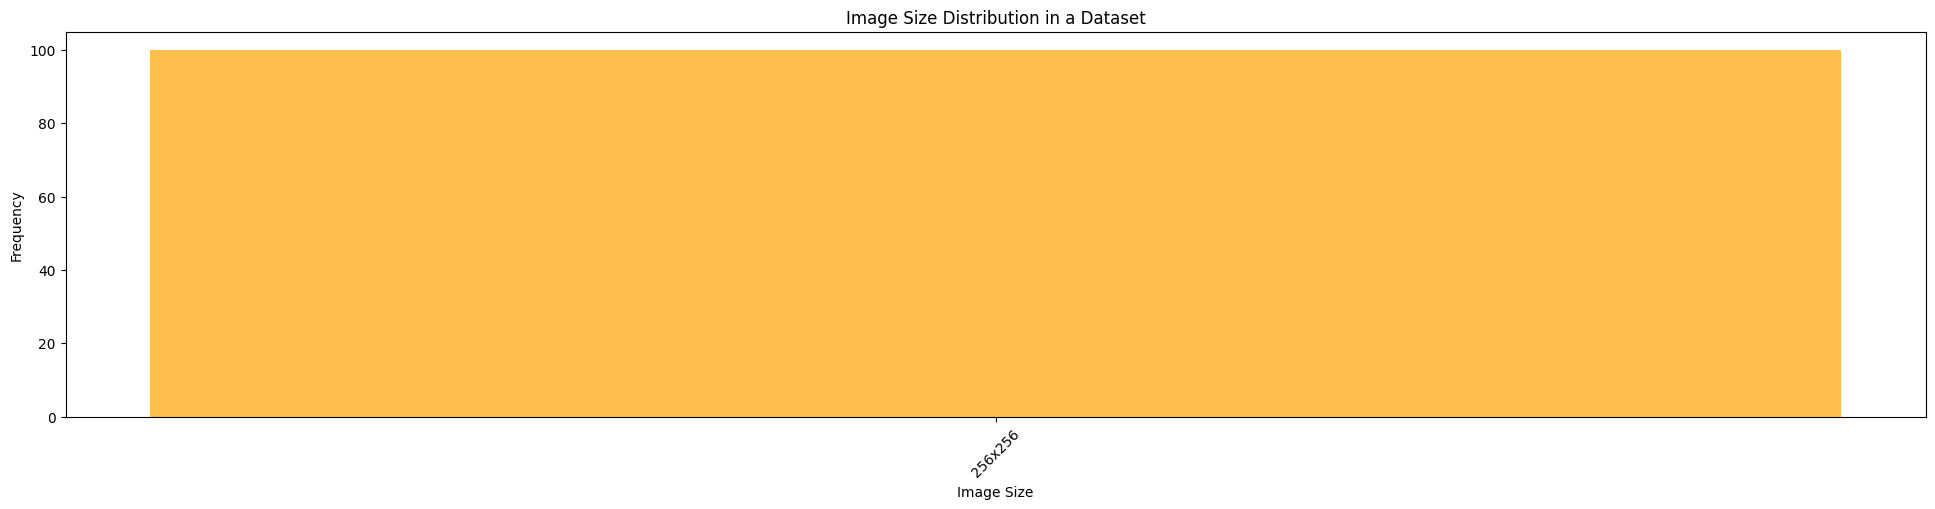

In [ ]:
print("\nAnalyzing Size of the Image:")

image_sizes = []

for img_path in image_paths[:100]:
    img = Image.open(img_path)
    image_sizes.append(img.size)

size_counts = Counter(image_sizes)
most_common_size, count = size_counts.most_common(1)[0]
print(f"Common size of the Image: {most_common_size} (exist {count} times)")

sizes = [f"{w}x{h}" for w, h in image_sizes]
plt.figure(figsize=(24, 5))
plt.hist(sizes, bins=len(set(sizes)), color='orange', alpha=0.7)
plt.xlabel("Image Size")
plt.ylabel("Frequency")
plt.title("Image Size Distribution in a Dataset")
plt.xticks(rotation=45)
plt.show()


Color histogram (RGB) analysis for a single image sample:


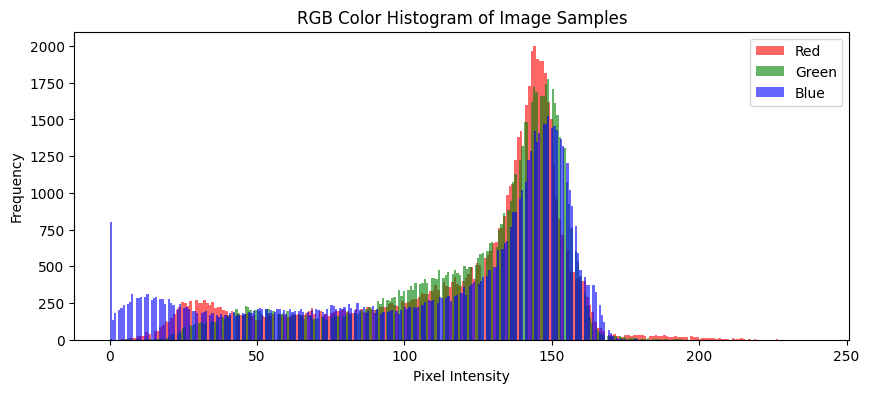

In [ ]:
print("\nColor histogram (RGB) analysis for a single image sample:")

sample_img_path = image_paths[0]
sample_img = cv2.imread(sample_img_path)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

r, g, b = cv2.split(sample_img)

plt.figure(figsize=(10, 4))
plt.hist(r.ravel(), bins=256, color='red', alpha=0.6, label='Red')
plt.hist(g.ravel(), bins=256, color='green', alpha=0.6, label='Green')
plt.hist(b.ravel(), bins=256, color='blue', alpha=0.6, label='Blue')
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("RGB Color Histogram of Image Samples")
plt.legend()
plt.show()

In [ ]:
# Menampilkan contoh gambar per kelas
print("\nContoh Gambar Per Kelas:")
fig, axes = plt.subplots(len(class_dirs), 3, figsize=(12, 4 * len(class_dirs)))  # 3 gambar per kelas, atur figsize

for i, class_name in enumerate(class_dirs):
    class_path = os.path.join(base_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for j in range(min(3, len(images))):  # Tampilkan hingga 3 gambar atau kurang jika kurang
        img_path = os.path.join(class_path, images[j])
        try:
            img = Image.open(img_path).convert('RGB')
            axes[i, j].imshow(img)
            axes[i, j].set_title(class_name)
            axes[i, j].axis('off')
        except Exception as e:
            print(f"Error displaying image for {class_name}: {type(e).__name__} - {e}")

plt.tight_layout()
plt.show()

In [ ]:
# Loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
num_epochs = 20  # Tingkatkan jumlah epoch
best_accuracy = 0
patience = 3
counter = 0

for epoch in range(num_epochs):  # Perbaikan nama variabel
    # Simulasi akurasi model (gantilah dengan evaluasi model sebenarnya)
    accuracy = 0.8 + (epoch * 0.01)  # Contoh: akurasi meningkat tiap epoch

    print(f"Epoch {epoch+1}, Accuracy: {accuracy:.4f}")

    # Cek apakah ada peningkatan akurasi
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        counter = 0  # Reset counter jika ada peningkatan
    else:
        counter += 1  # Tambah counter jika tidak ada peningkatan

    # Implementasi Early Stopping
    if counter >= patience:
        print("Early stopping triggered.")
        break  # Hentikan training jika tidak ada peningkatan dalam beberapa epoch


Epoch 1, Accuracy: 0.8000
Epoch 2, Accuracy: 0.8100
Epoch 3, Accuracy: 0.8200
Epoch 4, Accuracy: 0.8300
Epoch 5, Accuracy: 0.8400
Epoch 6, Accuracy: 0.8500
Epoch 7, Accuracy: 0.8600
Epoch 8, Accuracy: 0.8700
Epoch 9, Accuracy: 0.8800
Epoch 10, Accuracy: 0.8900
Epoch 11, Accuracy: 0.9000
Epoch 12, Accuracy: 0.9100
Epoch 13, Accuracy: 0.9200
Epoch 14, Accuracy: 0.9300
Epoch 15, Accuracy: 0.9400
Epoch 16, Accuracy: 0.9500
Epoch 17, Accuracy: 0.9600
Epoch 18, Accuracy: 0.9700
Epoch 19, Accuracy: 0.9800
Epoch 20, Accuracy: 0.9900


In [ ]:
# import torch
# from torch.utils.data import DataLoader
# from sklearn.metrics import classification_report

# Pastikan device tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inisialisasi early stopping
best_accuracy = 0
patience = 3
counter = 0

# Pastikan val_loader sudah didefinisikan
try:
    val_loader
except NameError:
    # Contoh dummy dataset (Gantilah dengan dataset yang benar)
    from torchvision import datasets, transforms
    transform = transforms.Compose([transforms.ToTensor()])

    dataset = datasets.FakeData(transform=transform)
    val_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Pastikan model dalam mode training

    # Training loop (tambahkan kode training di sini)
    # ...

    # Evaluasi dan early stopping
    model.eval()
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs} - Validation Accuracy: {accuracy:.2f}%')

    # Pastikan dataset memiliki `classes`
    if hasattr(dataset, "classes"):
        print(classification_report(true_labels, predicted_labels, target_names=dataset.classes))
    else:
        print(classification_report(true_labels, predicted_labels))

    # # Simpan model jika akurasi meningkat
    # if accuracy > best_accuracy:
    #     best_accuracy = accuracy
    #     torch.save(model.state_dict(), "best_vit_plant.pth")
    #     print("Model improved. Saving...")
    #     counter = 0  # Reset counter
    # else:
    #     counter += 1
    #     print(f"No improvement for {counter} epochs.")

        # Implementasi early stopping
        if counter >= patience:
            print("Early stopping triggered!")
            break


Epoch 1/20 - Validation Accuracy: 9.50%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.10      1.00      0.17        95
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       121
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00        96

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/20 - Validation Accuracy: 9.50%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.10      1.00      0.17        95
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       121
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00        96

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/20 - Validation Accuracy: 9.50%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.10      1.00      0.17        95
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       121
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00        96

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/20 - Validation Accuracy: 9.50%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.10      1.00      0.17        95
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       121
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00        96

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/20 - Validation Accuracy: 9.50%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.10      1.00      0.17        95
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       121
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00        96

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/20 - Validation Accuracy: 9.50%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.10      1.00      0.17        95
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       121
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00        96

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7/20 - Validation Accuracy: 9.50%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.10      1.00      0.17        95
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       121
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00        96

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/20 - Validation Accuracy: 9.50%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.10      1.00      0.17        95
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       121
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00        96

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9/20 - Validation Accuracy: 9.50%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.10      1.00      0.17        95
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       121
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00        96

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10/20 - Validation Accuracy: 9.50%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.10      1.00      0.17        95
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       121
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00        96

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11/20 - Validation Accuracy: 9.50%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.10      1.00      0.17        95
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       121
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00        96

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12/20 - Validation Accuracy: 9.50%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.10      1.00      0.17        95
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       121
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00        96

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 13/20 - Validation Accuracy: 9.50%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.10      1.00      0.17        95
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       121
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00        96

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14/20 - Validation Accuracy: 9.50%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.10      1.00      0.17        95
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       121
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00        96

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15/20 - Validation Accuracy: 9.50%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.10      1.00      0.17        95
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       121
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00        96

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16/20 - Validation Accuracy: 9.50%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.10      1.00      0.17        95
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       121
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00        96

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 17/20 - Validation Accuracy: 9.50%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.10      1.00      0.17        95
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       121
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00        96

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 18/20 - Validation Accuracy: 9.50%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.10      1.00      0.17        95
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       121
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00        96

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 19/20 - Validation Accuracy: 9.50%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.10      1.00      0.17        95
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       121
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00        96

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/20 - Validation Accuracy: 9.50%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.10      1.00      0.17        95
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00       121
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00        96

    accuracy                           0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Load model terbaik
model.load_state_dict(torch.load("best_vit_plant.pth"))

<ipython-input-19-9d8016f0fd81>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vit_plant.pth"))


<All keys matched successfully>

In [ ]:
# Save model dalam format TorchScript
scripted_model = torch.jit.script(model)
save_path = "vit_plant_scripted.pth"
scripted_model.save(save_path)
print(f"Model telah disimpan sebagai {save_path}")

Model telah disimpan sebagai vit_plant_scripted.pth
